<a href="https://colab.research.google.com/github/nitingarg2015/EVA8/blob/master/Assignment%202.5/Assignment_2-5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from __future__ import print_function #to bring the print function from Python 3 into Python 2
import torch #import torch package
import torch.nn as nn #import neural network module from torch - basic building blocks for graphs
import torch.nn.functional as F #import functional package from nn as F. this contains various neural network functions
import torch.optim as optim #import package implementing various optimization algorithms
from torchvision import datasets, transforms #import datasets and common image transformations from torchvision
from torch.utils.data import Dataset
import numpy as np

In [2]:
#Torch-summary provides information complementary to what is provided by print(your_model) in PyTorch
!pip install torchsummary
from torchsummary import summary

#use_cuda returns True if cuda is available
use_cuda = torch.cuda.is_available()

#device set to "cuda" if available else set to cpu
device = torch.device("cuda" if use_cuda else "cpu")

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
#seed value to ensure repeatability
torch.manual_seed(1)

train_set = datasets.MNIST('../data', train=True, download=True,
                    transform=transforms.Compose([
                        transforms.ToTensor(),
                        transforms.Normalize((0.1307,), (0.3081,))
                    ]))

test_set = datasets.MNIST('../data', train=False, transform=transforms.Compose([
                        transforms.ToTensor(),
                        transforms.Normalize((0.1307,), (0.3081,))
                    ]))


  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ../data/MNIST/raw/train-images-idx3-ubyte.gz to ../data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ../data/MNIST/raw/train-labels-idx1-ubyte.gz to ../data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ../data/MNIST/raw/t10k-images-idx3-ubyte.gz to ../data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ../data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ../data/MNIST/raw



## Define custom dataset for combined data

In [4]:
#Define ComboDataset class. This class accepts the MNIST data. It adds a random number to this dataset, and returns four items 
#as dictionary: 1) image, 2) Random Number, 3) First Label - label1 - actual label for the image, and 
#4) Second label - labe2 - sum of random number and first label

class ComboDataset(Dataset):
    """Image dataset and random number."""

    def __init__(self, imageset):
        self.imageset = imageset

    def __len__(self):
        return len(self.imageset)

    def __getitem__(self, idx):

        rand_x = np.random.randint(0,10)   #generate random number between 0 and 9

        return {
            "img": self.imageset[idx][0],               #image
            "numb": F.one_hot(torch.tensor(rand_x), num_classes=10),  #one hot encoding to be concatenated later
            "label1": self.imageset[idx][1],            #training label for image
            "label2": rand_x + self.imageset[idx][1]    #training label for sum of random number and image number
        }


In [5]:
train_set_wnumb = ComboDataset(train_set)   #generate training set from ComboDataset dataset
test_set_wnumb = ComboDataset(test_set)     #generate test set from ComboDataset dataset

In [6]:
##check output of the dataset
t1 = train_set_wnumb[1]
t1['numb'], t1['label1'], t1['label2']

## random number output is 1-D, 10 classes tensor, while labels are integers

(tensor([0, 0, 0, 0, 1, 0, 0, 0, 0, 0]), 0, 4)

In [7]:
#Use DataLoader class to load Combodataset and form train & test dataloaders

#define batch size 128
batch_size = 128

kwargs = {'num_workers': 1, 'pin_memory': True} if use_cuda else {}

train_loader = torch.utils.data.DataLoader(
    train_set_wnumb,
    batch_size=batch_size, shuffle=True, **kwargs)

test_loader = torch.utils.data.DataLoader(
    test_set_wnumb,
    batch_size=batch_size, shuffle=True, **kwargs)

## Visualize dataset

In [8]:
batch = next(iter(train_loader))
images, labels = batch['img'], batch['label1']

images.shape, labels.shape

(torch.Size([128, 1, 28, 28]), torch.Size([128]))

labels: tensor([4, 8, 8, 6, 7, 1, 0, 7, 1, 8, 7, 6, 4, 9, 1, 5, 3, 2, 6, 8, 8, 6, 9, 4,
        6, 0, 4, 2, 6, 7, 0, 5, 8, 6, 0, 3, 5, 7, 4, 7, 5, 1, 6, 7, 3, 6, 0, 3,
        1, 1, 2, 6, 7, 9, 8, 0, 7, 2, 4, 3, 6, 5, 9, 5, 2, 3, 5, 3, 5, 8, 9, 2,
        7, 1, 2, 4, 0, 2, 0, 6, 7, 2, 9, 5, 7, 1, 2, 2, 3, 3, 8, 8, 1, 0, 5, 7,
        5, 9, 6, 7, 2, 5, 9, 7, 5, 7, 1, 7, 8, 7, 8, 8, 8, 2, 1, 4, 1, 1, 3, 2,
        9, 5, 1, 9, 0, 3, 0, 3])


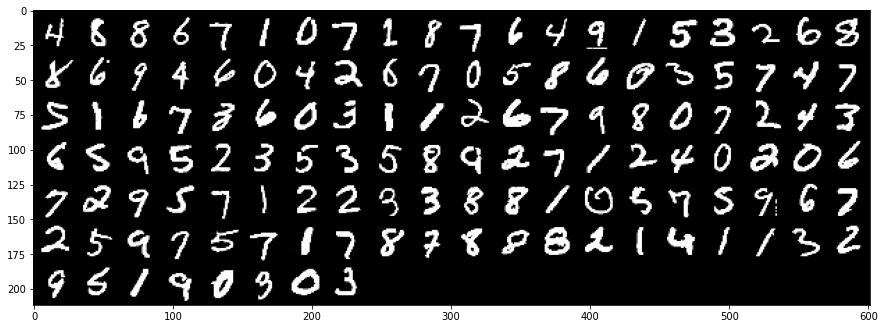

In [9]:
import torchvision
import matplotlib.pyplot as plt

grid = torchvision.utils.make_grid(images, nrow=20)
plt.figure(figsize=(15,15))
plt.imshow(np.transpose(grid, (1,2,0)))
print('labels:', labels)

In [10]:
random_numbers, sum_labels = batch['numb'], batch['label2']

print(random_numbers.shape, sum_labels.shape)
print(labels)
print(random_numbers)
print(sum_labels)

torch.Size([128, 10]) torch.Size([128])
tensor([4, 8, 8, 6, 7, 1, 0, 7, 1, 8, 7, 6, 4, 9, 1, 5, 3, 2, 6, 8, 8, 6, 9, 4,
        6, 0, 4, 2, 6, 7, 0, 5, 8, 6, 0, 3, 5, 7, 4, 7, 5, 1, 6, 7, 3, 6, 0, 3,
        1, 1, 2, 6, 7, 9, 8, 0, 7, 2, 4, 3, 6, 5, 9, 5, 2, 3, 5, 3, 5, 8, 9, 2,
        7, 1, 2, 4, 0, 2, 0, 6, 7, 2, 9, 5, 7, 1, 2, 2, 3, 3, 8, 8, 1, 0, 5, 7,
        5, 9, 6, 7, 2, 5, 9, 7, 5, 7, 1, 7, 8, 7, 8, 8, 8, 2, 1, 4, 1, 1, 3, 2,
        9, 5, 1, 9, 0, 3, 0, 3])
tensor([[0, 1, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 1],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 1, 0],
        [1, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]])
tensor([ 5, 17, 13,  6, 15,  7,  5,  9,  4,  8, 16, 15,  5,  9,  9, 10, 11,  8,
        14, 13, 13, 11, 10, 12, 15,  3, 13,  9,  9, 11,  6, 14, 12,  9,  3,  4,
        10,  9,  9,  8,  6,  8, 10, 10,  9,  8,  4,  8,  2,  3,  5, 11, 11, 18,
        17,  7, 14,  5,  7,  5, 11,  7, 10, 13,  6,  9,  6,  3,  9, 1

In [11]:
#frequency counts of each of images in training set
train_set.targets.bincount()

tensor([5923, 6742, 5958, 6131, 5842, 5421, 5918, 6265, 5851, 5949])

In [12]:
#frequency counts of each of images in test set
test_set.targets.bincount()

tensor([ 980, 1135, 1032, 1010,  982,  892,  958, 1028,  974, 1009])

## Create Net class for defining the neural network

In [13]:
class Net(nn.Module):
    def __init__(self):

        #inherit all properties of nn.Module by defining super
        super(Net, self).__init__()

        # First 2D convolutional layer, taking in 1 input channel (image),
        # outputting 32 convolutional features, with a square kernel size of 3 and padding of 1
        self.conv1 = nn.Conv2d(1, 32, 3, padding=1) #input: (-1,1,28,28) - Output: (-1,32,28,28) RF: (3,3)
        
        # Second 2D convolutional layer, taking in 32 input channels,
        # outputting 64 convolutional features, with a square kernel size of 3 and padding of 1
        self.conv2 = nn.Conv2d(32, 64, 3, padding=1) #input: (-1,32,28,28), Output: (-1,64,28,28), RF: (5,5)

        self.pool1 = nn.MaxPool2d(2, 2) #input: (-1,64,28,28), Output: (-1,64,14,14), RF: (10,10)

        #Output channels: 128, kernel size: 3
        self.conv3 = nn.Conv2d(64, 128, 3, padding=1) #input: (-1,64,14,14), Output: (-1,128,14,14), RF: (12,12)

        #Output channels: 256, kernel size: 3
        self.conv4 = nn.Conv2d(128, 256, 3, padding=1) #input: (-1,128,14,14), Output: (-1,256,14,14), RF: (14,14)

        self.pool2 = nn.MaxPool2d(2, 2) #input: (-1,256,14,14), Output: (-1,256,7,7), RF: (28, 28)

        #Output channels: 512, kernel size: 3
        self.conv5 = nn.Conv2d(256, 512, 3) #input: (-1,256,7,7), Output: (-1,512,5,5), RF: (30, 30)

        #Output channels: 10, kernel size: 3
        self.conv6 = nn.Conv2d(512, 10, 3) #input: (-1,512,5,5), Output: (-1,10,3,3), RF: (32, 32)

        self.fc1 = nn.Linear(in_features=10*3*3, out_features=10)

        self.fc2 = nn.Linear(in_features = 20, out_features = 32)

        self.fc3 = nn.Linear(in_features = 32, out_features = 19)
        
    #define the forward function, that will pass the data into the our neural network. This will represent our feed-forward algorithm.
    def forward(self, imgdata, numbdata):
        #Pass data through self.conv1, use relu activation function, then pass it through self.conv2 and then apply relu activation function again on it
        #apply pooling layer self.pool1 on this output
        
        x = imgdata

        x = self.pool1(F.relu(self.conv2(F.relu(self.conv1(x)))))
        
        #Pass data through self.conv3, use relu activation function, then pass it through self.conv4 and then apply relu activation function again on it
        #apply pooling layer self.pool2 on this output
        x = self.pool2(F.relu(self.conv4(F.relu(self.conv3(x)))))

        #Pass data through self.conv5, use relu activation function, then pass it through self.conv6 and then apply relu activation function again on it
        x = F.relu(self.conv6(F.relu(self.conv5(x))))

        #convert to 1D tensor                  
        x = x.view(-1, 10*3*3)
        
        #Pass data through self.fc1 and apply relu activation function - output for predicting images
        x = F.relu(self.fc1(x))

        #concatenate with output of previous step, and apply relu activation to the overall
        x1 = torch.concat([F.softmax(x, dim = -1),numbdata], dim = -1)
        
        #Pass data through self.fc1 and apply relu activation function - output for predicting the sum
        x1 = self.fc3(self.fc2(x1))
        
        return F.log_softmax(x, dim = -1), F.log_softmax(x1, dim = -1)
        #return x, numbdata

## Test Feed forward network to check if desired output is obtained

In [14]:
#initialize Net class
model = Net().to(device)

#generate sample data
batch = next(iter(train_loader))
total_loss = 0

img_data = batch['img'].to(device)
img_label = batch['label1'].to(device)
numb_data = batch['numb'].to(device)
sum_label = batch['label2'].to(device)

output = model(img_data, numb_data)

output[0].shape, output[1].shape

(torch.Size([128, 10]), torch.Size([128, 19]))

In [15]:
#Evaluate and print loss
loss1 = F.nll_loss(output[0], img_label)
loss2 = F.nll_loss(output[1], sum_label)

total_loss = loss1+loss2

print(loss1, loss2, total_loss)

tensor(2.2992, device='cuda:0', grad_fn=<NllLossBackward0>) tensor(2.9604, device='cuda:0', grad_fn=<NllLossBackward0>) tensor(5.2595, device='cuda:0', grad_fn=<AddBackward0>)


In [16]:
#Run one iteration of forward and backward pass
#set optimizer as SGD optimizer with learning rate of 0.01 and momentum of 0.9
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

optimizer.zero_grad()
output = model(img_data, numb_data)

loss1 = F.nll_loss(output[0], img_label)
loss2 = F.nll_loss(output[1], sum_label)

total_loss = loss1+loss2
print(loss1, loss2, total_loss)

total_loss.backward()

#update the weights
optimizer.step()

optimizer.zero_grad()
output = model(img_data, numb_data)

loss1 = F.nll_loss(output[0], img_label)
loss2 = F.nll_loss(output[1], sum_label)
print(loss1, loss2, total_loss)


tensor(2.2992, device='cuda:0', grad_fn=<NllLossBackward0>) tensor(2.9604, device='cuda:0', grad_fn=<NllLossBackward0>) tensor(5.2595, device='cuda:0', grad_fn=<AddBackward0>)
tensor(2.2989, device='cuda:0', grad_fn=<NllLossBackward0>) tensor(2.9597, device='cuda:0', grad_fn=<NllLossBackward0>) tensor(5.2595, device='cuda:0', grad_fn=<AddBackward0>)


## Define functions for training and test results

In [23]:
#import tqdm package to display progress bars
from tqdm import tqdm

#function to train, input parameters: model, device, train dataset, optimizer function and number of epochs
def train(model, device, train_loader, optimizer, epoch):
    
    #sets the model in training mode
    model.train()
    
    #create an iterator
    pbar = tqdm(train_loader)

    # enumerate adds counter to pbar which is captured under batch_idx, iterating through it we also get data set in the batch, 
    # and the target value of each data point in that batch
    for batch_idx, data in enumerate(pbar):
        img_data = data['img'].to(device)
        img_label = data['label1'].to(device)
        numb_data = data['numb'].to(device)
        sum_label = data['label2'].to(device)

    #initialize the optimizer, set the gradients to zero
        optimizer.zero_grad()

        # perform a forward pass and calculate the training loss
        output = model(img_data, numb_data)
        loss1 = F.nll_loss(output[0], img_label)*1.2
        loss2 = F.nll_loss(output[1], sum_label)
        total_loss = loss1+loss2

        # perform a forward pass and calculate the training loss
        total_loss.backward()
        
        #update the weights
        optimizer.step()
        pbar.set_description(desc= f'loss1={loss1.item()} loss2={loss2.item()} batch_id={batch_idx}')

def test(model, device, test_loader):
    #set the model in evaluation mode
    model.eval()
    #initialize variables
    test_loss = 0
    img_correct = 0
    sum_correct = 0

    with torch.no_grad():
        for data in test_loader:
            img_data = data['img'].to(device)
            img_label = data['label1'].to(device)
            numb_data = data['numb'].to(device)
            sum_label = data['label2'].to(device)
            
            # perform a forward pass and calculate the test loss
            output = model(img_data, numb_data)

            loss1 = F.nll_loss(output[0], img_label)
            loss2 = F.nll_loss(output[1], sum_label)
            int_loss = loss1+loss2
            test_loss += int_loss.item()  # sum up batch loss
            
            pred1 = output[0].argmax(dim=1, keepdim=True).squeeze()
            img_correct += pred1.eq(img_label.view_as(pred1)).sum().item()

            pred2 = output[1].argmax(dim=1, keepdim=True).squeeze()
            sum_correct += pred2.eq(sum_label.view_as(pred2)).sum().item()

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, img_correct, len(test_loader.dataset),
        100. * img_correct / len(test_loader.dataset)))

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, sum_correct, len(test_loader.dataset),
        100. * sum_correct / len(test_loader.dataset)))

## Initialize the custom class and train the model

In [24]:
#initialize Net class
model = Net().to(device)

#set optimizer as SGD optimizer with learning rate of 0.01 and momentum of 0.9
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

#train the model for defined epochs and calculate test loss for each iteration
for epoch in range(1, 10):
    train(model, device, train_loader, optimizer, epoch)

loss1=0.3969745337963104 loss2=2.2540283203125 batch_id=468: 100%|██████████| 469/469 [00:43<00:00, 10.85it/s]
loss1=0.3554614782333374 loss2=1.7770007848739624 batch_id=468: 100%|██████████| 469/469 [00:43<00:00, 10.73it/s]
loss1=0.2733469605445862 loss2=1.5332813262939453 batch_id=468: 100%|██████████| 469/469 [00:43<00:00, 10.77it/s]
loss1=0.4271211624145508 loss2=1.3183006048202515 batch_id=468: 100%|██████████| 469/469 [00:43<00:00, 10.70it/s]
loss1=0.06270455569028854 loss2=1.094084620475769 batch_id=468: 100%|██████████| 469/469 [00:43<00:00, 10.67it/s]
loss1=0.05009601637721062 loss2=0.9944959282875061 batch_id=468: 100%|██████████| 469/469 [00:43<00:00, 10.72it/s]
loss1=0.009853420779109001 loss2=0.8902330994606018 batch_id=468: 100%|██████████| 469/469 [00:43<00:00, 10.71it/s]
loss1=0.00157591188326478 loss2=0.8045685887336731 batch_id=468: 100%|██████████| 469/469 [00:43<00:00, 10.70it/s]
loss1=0.026304995641112328 loss2=0.7271203398704529 batch_id=468: 100%|██████████| 469/

## Run test data to get the test output

In [25]:
test(model, device, test_loader)


Test set: Average loss: 63.9103, Accuracy: 9919/10000 (99%)


Test set: Average loss: 63.9103, Accuracy: 9392/10000 (94%)

